# The data

In [1]:
import pandas as pd
df = pd.read_csv('db.csv')

In [2]:
df = df[['1', '2']]

In [3]:
df

,1,2
0,<!DOCTYPE html>\n <!--[if lte IE 9]><html c...,negative
1,"\n <!DOCTYPE html>\n <html lang=""pt-BR"">\n ...",negative
2,"\n <!DOCTYPE html>\n <html lang=""pt-BR"">\n ...",negative
3,<!DOCTYPE html>\n <!--[if lte IE 9]><html c...,negative
4,"\n <!DOCTYPE html>\n <html lang=""pt-BR"">\n ...",negative
...,...,...
207,<!DOCTYPE html >\r\n<!--versioncontrol 05/10/2...,positive
208,<!DOCTYPE html >\r\n<!--versioncontrol 05/10/2...,positive
209,<!DOCTYPE html >\r\n<!--versioncontrol 05/10/2...,positive
210,<!DOCTYPE html >\r\n<!--versioncontrol 05/10/2...,positive


# Feature creation

In [4]:
from bs4 import BeautifulSoup

In [5]:
htmls = df['1']

In [6]:
text = []
for html in htmls:
    soup = BeautifulSoup(html)
    for script in soup(["script", "style"]):
        script.extract()    # rip it out
    text.append(soup.get_text())

In [7]:
import unidecode

text = [unidecode.unidecode(s) for s in text]

In [8]:
#Substitute point and go to lower case
import re

text = [re.sub('[^A-Za-z]', ' ', s) for s in text]
text = [s.lower() for s in text]

In [9]:
#Remove stopwords
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /home/sergio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sergio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
data = []
for s in text:
    tokenized_text = word_tokenize(s)
    for word in tokenized_text:
        if word in stopwords.words('portuguese'):
            tokenized_text.remove(word)
        
    s_text = " ".join(tokenized_text)
    data.append(s_text)

In [11]:
#Bag of words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer as tf_idf

In [12]:
#Pega todas as palavras em cada SMS e depois conta o número de ocorrencias de cada uma
#Depois selecionamos as palavras que aparecem mais que outras. Exemplo: selecionar as primeiras X palavras
matrix = tf_idf(max_features=500)
X = matrix.fit_transform(data).toarray()
y = df.iloc[:, 1]

In [13]:
bow_df = pd.DataFrame(X, columns = matrix.get_feature_names())

In [14]:
bow_df

,abrir,acesse,acessibilidade,acesso,acessorios,acima,add,adicionar,administracao,agora,...,vistaou,vitaminas,viu,voce,vol,volta,voltar,warningicone,www,xbox
0,0.065999,0.028100,0.063310,0.0,0.0,0.152182,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.014180,0.0,0.000000,0.00000,0.070301,0.13672,0.000000
1,0.120682,0.051381,0.115765,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.077786,0.0,0.000000,0.00000,0.128548,0.00000,0.000000
2,0.096016,0.040880,0.092104,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.020629,0.0,0.000000,0.04088,0.102274,0.00000,0.000000
3,0.019248,0.005463,0.012309,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.005514,0.0,0.006256,0.00000,0.013669,0.00000,0.000000
4,0.091353,0.038894,0.087631,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.039255,0.0,0.000000,0.00000,0.097308,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,0.040697,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.032212,...,0.0,0.0,0.039357,0.104927,0.0,0.000000,0.00000,0.000000,0.00000,0.122092
208,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.073119,...,0.0,0.0,0.053604,0.047636,0.0,0.036031,0.00000,0.000000,0.00000,0.055429
209,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.013384,...,0.0,0.0,0.016354,0.065398,0.0,0.016488,0.00000,0.000000,0.00000,0.050731
210,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.076571,...,0.0,0.0,0.037423,0.041571,0.0,0.113195,0.00000,0.000000,0.00000,0.058045


In [15]:
import pickle

In [18]:
pickle.dump(matrix, open('bow.pkl', 'wb'))

# Model

In [25]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

## First model -> GaussianNB

I'll Fine tune var_smoothing parameter. var_smoothing parameter is responsible to add a user-defined value to distribution variance in order to smooth or wide the gaussian curver that will be fit.

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [27]:
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [28]:
# Primeiro Modelo: Naive Bayes Classifier
import time
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import numpy as np

gnb = GaussianNB()
params = {'var_smoothing': np.logspace(0,-9, num=10)}

gs = GridSearchCV(estimator=gnb, param_grid=params)
start = time.time()
gs.fit(X_train_std, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
tt_gnb = stop - start

Training time: 0.14197921752929688s


In [29]:
gnb = gs.best_estimator_
gnb.fit(X_train_std, y_train)

GaussianNB(var_smoothing=1.0)

Now, I'll evaluate the model -> ROC/AUC score and Confusion Matrix

In [30]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score

In [31]:
y_pred_class = gnb.predict(X_test_std)

In [32]:
accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class, average='binary', pos_label='negative')
precision = precision_score(y_test, y_pred_class,  average='binary', pos_label='negative')
f1 = f1_score(y_test, y_pred_class,  average='binary', pos_label='negative')
acc_gnb = (accuracy, recall, precision, f1)

print('f1 score:', f1)
print('precision:', precision)
print('recall:', recall)
print('accuracy', accuracy)

f1 score: 0.8085106382978724
precision: 0.95
recall: 0.7037037037037037
accuracy 0.8301886792452831


<AxesSubplot:>

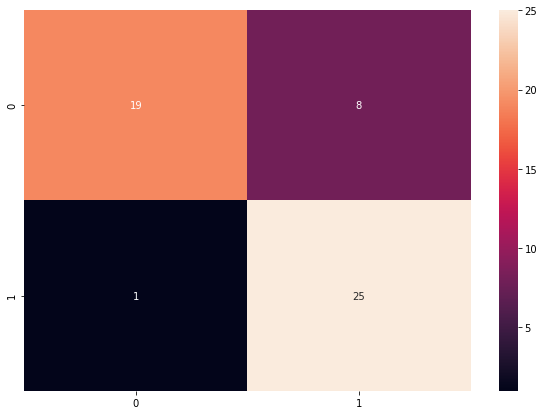

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_class), index = [0,1],columns = [0,1])


# TN FP
# FN TP
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## Second model -> SVM 

I'll Fine tune three parameter of SVM:

- Kernels: transform a low dimension input space in higher dimensional input space
- C: misclassification parameter. Tells SVM how much error is acceptable.
- Gamma: defines how far points influence in line separation.

In [77]:
from sklearn.svm import SVC  
svm = SVC()
params = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

gs = GridSearchCV(estimator=svm, param_grid=params)
start = time.time()
gs.fit(X_train_std, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
tt_svm = stop-start

Training time: 1.3276112079620361s


In [78]:
svm = gs.best_estimator_
svm.fit(X_train_std, y_train)

SVC(C=10, gamma=0.001)

In [79]:
y_pred_class = svm.predict(X_test_std)

In [80]:
accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class, average='binary', pos_label='negative')
precision = precision_score(y_test, y_pred_class,  average='binary', pos_label='negative')
f1 = f1_score(y_test, y_pred_class,  average='binary', pos_label='negative')
acc_svm = (accuracy, recall, precision, f1)

print('f1 score:', f1)
print('precision:', precision)
print('recall:', recall)
print('accuracy', accuracy)

f1 score: 0.9199999999999999
precision: 0.9583333333333334
recall: 0.8846153846153846
accuracy 0.9245283018867925


<AxesSubplot:>

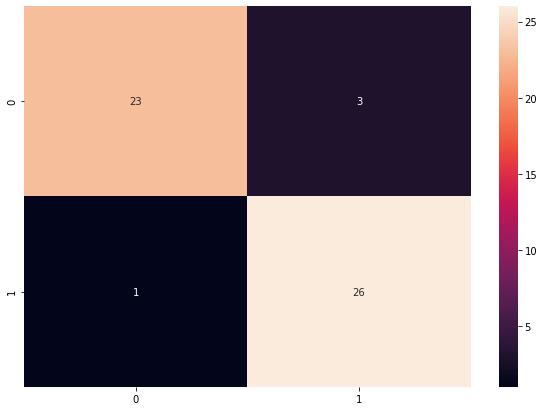

In [81]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_class), index = [0,1],columns = [0,1])


# TN FP
# FN TP
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## Third model -> Random Forest

I'll Fine tune four parameters of RF:

- n_estimators: number of trees in the forest
- max_features: number of features considered to split a node
- max_depth: max depth of each tree
- min_samples_leaf: min number of data points in leaf node

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

params= {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'n_estimators': [100, 200, 300, 1000]
}

gs = GridSearchCV(estimator=rf, param_grid=params)
start = time.time()
gs.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
tt_rf = stop-start

Training time: 216.46613144874573s


In [35]:
rf = gs.best_estimator_
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=80, max_features=3, min_samples_leaf=5)

In [36]:
y_pred_class = rf.predict(X_test)

In [37]:
accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class, average='binary', pos_label='negative')
precision = precision_score(y_test, y_pred_class,  average='binary', pos_label='negative')
f1 = f1_score(y_test, y_pred_class,  average='binary', pos_label='negative')
acc_rf = (accuracy, recall, precision, f1)

print('f1 score:', f1)
print('precision:', precision)
print('recall:', recall)
print('accuracy', accuracy)

f1 score: 0.923076923076923
precision: 0.96
recall: 0.8888888888888888
accuracy 0.9245283018867925


<AxesSubplot:>

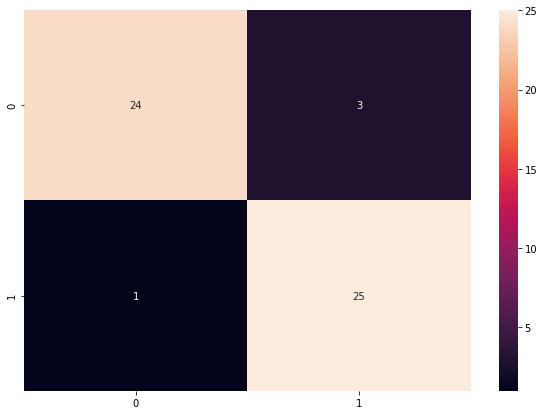

In [38]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_class), index = [0,1],columns = [0,1])


# TN FP
# FN TP
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [40]:
pickle.dump(rf, open('model.pkl', 'wb'))

## Fourth model -> Log Reg

I'll Fine tune C parameter of logreg, which is the one that controls regularization. Lower C, more regularization we add to the model.


In [87]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=100000)

params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

gs = GridSearchCV(estimator=logreg, param_grid=params)
start = time.time()
gs.fit(X_train_std, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
tt_lr = stop-start

Training time: 0.3800802230834961s


In [88]:
logreg = gs.best_estimator_
logreg.fit(X_train_std, y_train)

LogisticRegression(C=1000, max_iter=100000)

In [89]:
y_pred_class = logreg.predict(X_test_std)

In [90]:
accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class, average='binary', pos_label='negative')
precision = precision_score(y_test, y_pred_class,  average='binary', pos_label='negative')
f1 = f1_score(y_test, y_pred_class,  average='binary', pos_label='negative')
acc_lr = (accuracy, recall, precision, f1)

print('f1 score:', f1)
print('precision:', precision)
print('recall:', recall)
print('accuracy', accuracy)

f1 score: 0.875
precision: 0.9545454545454546
recall: 0.8076923076923077
accuracy 0.8867924528301887


<AxesSubplot:>

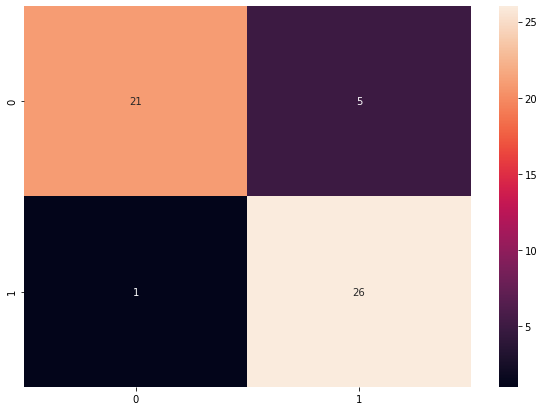

In [91]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_class), index = [0,1],columns = [0,1])


# TN FP
# FN TP
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## Fifth model -> MLP

I'll Fine tune four parameters of MLP:

- hidden_layer_sizes: o tamanho das camadas hidden
- alpha: parametro de regularização
- activation: função de ativação

In [92]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100000)

params = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],
}

gs = GridSearchCV(estimator=mlp, param_grid=params)
start = time.time()
gs.fit(X_train_std, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
tt_mlp = stop-start

Training time: 8.805759191513062s


In [93]:
mlp = gs.best_estimator_
mlp.fit(X_train_std, y_train)

MLPClassifier(alpha=0.05, hidden_layer_sizes=(50, 100, 50), max_iter=100000)

In [94]:
y_pred_class = mlp.predict(X_test_std)

In [95]:
accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class, average='binary', pos_label='negative')
precision = precision_score(y_test, y_pred_class,  average='binary', pos_label='negative')
f1 = f1_score(y_test, y_pred_class,  average='binary', pos_label='negative')
acc_mlp = (accuracy, recall, precision, f1)

print('f1 score:', f1)
print('precision:', precision)
print('recall:', recall)
print('accuracy', accuracy)

f1 score: 0.8400000000000001
precision: 0.875
recall: 0.8076923076923077
accuracy 0.8490566037735849


<AxesSubplot:>

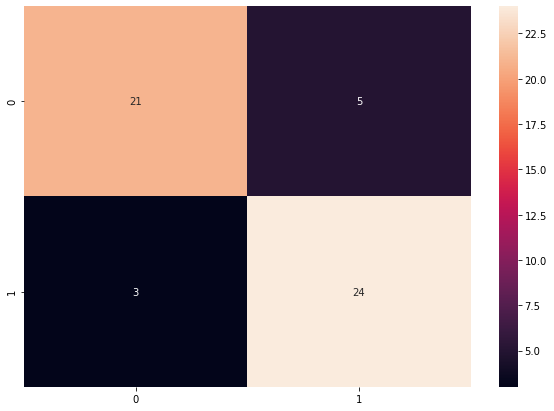

In [96]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_class), index = [0,1],columns = [0,1])


# TN FP
# FN TP
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

# Model comparision

<BarContainer object of 5 artists>

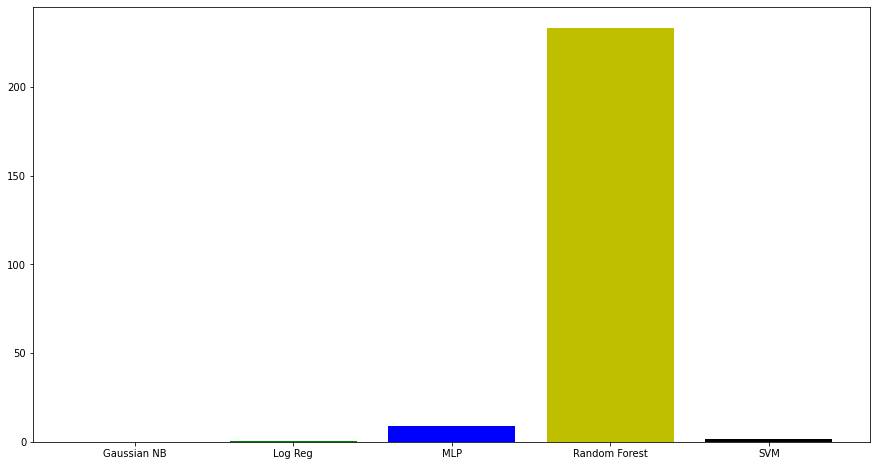

In [97]:
# Training time

tts = [tt_gnb, tt_lr, tt_mlp, tt_rf, tt_svm]
models = ['Gaussian NB', 'Log Reg', 'MLP', 'Random Forest', 'SVM']

plt.figure(figsize=(15,8))
plt.bar(models, tts, color=list('rgbyk'))

<AxesSubplot:>

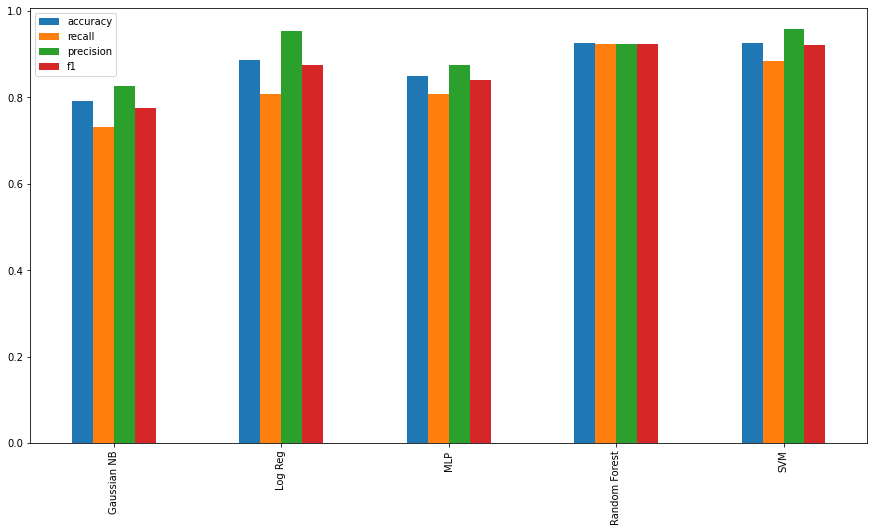

In [118]:
stats = ['accuracy', 'recall', 'precision', 'f1']
df_stats = pd.DataFrame(accs, index = models, columns=stats)
df_stats.plot(kind='bar', figsize=(15,8))